<a href="https://colab.research.google.com/github/yuuuuniii/Hotel-Booking-Cancellation-Analysis/blob/main/Hotel_Booking_Cancellation_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import Libraries

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 2.Load Dataset

In [139]:
# Mount Google Drive (if your CSV is stored there)
from google.colab import drive
drive.mount('/content/drive')
#
# Read the data
data = pd.read_csv('/content/drive/MyDrive/ST635/booking.csv')

data.head()
data.info()
print(data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  int64  
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  int64  
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  

# 3.EDA Analysis

In [140]:
# Basic statistics
print(data.describe())

#Check for unique values
print(data.nunique())

       number of adults  number of children  number of weekend nights  \
count      36285.000000        36285.000000              36285.000000   
mean           1.844839            0.105360                  0.810693   
std            0.518813            0.402704                  0.870590   
min            0.000000            0.000000                  0.000000   
25%            2.000000            0.000000                  0.000000   
50%            2.000000            0.000000                  1.000000   
75%            2.000000            0.000000                  2.000000   
max            4.000000           10.000000                  7.000000   

       number of week nights  type of meal  car parking space     room type  \
count           36285.000000  36285.000000       36285.000000  36285.000000   
mean                2.204602      0.949952           0.030977      1.708860   
std                 1.410946      0.480209           0.173258      1.399801   
min                 0.0000

In [141]:
#Check if there is null values
print(data.isnull().sum().sort_values(ascending=False))

Booking_ID                  0
market segment type         0
date of reservation         0
special requests            0
average price               0
P-not-C                     0
P-C                         0
repeated                    0
lead time                   0
number of adults            0
room type                   0
car parking space           0
type of meal                0
number of week nights       0
number of weekend nights    0
number of children          0
booking status              0
dtype: int64


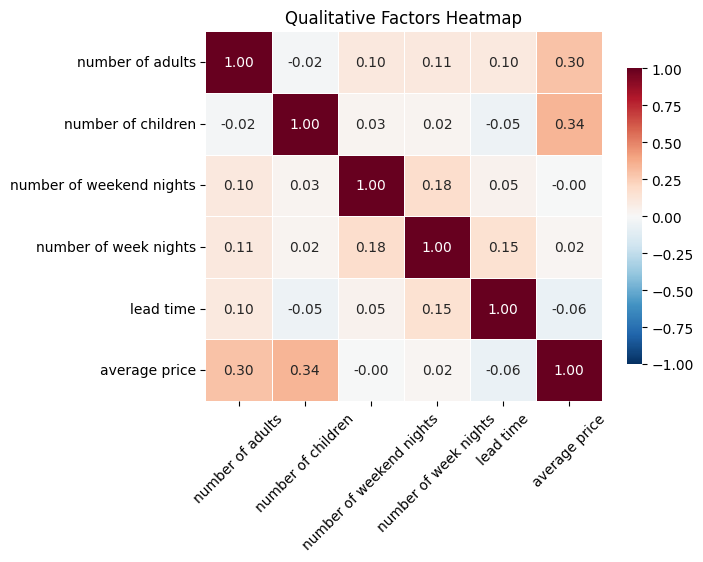

In [5]:
# Correlation matrix
numeric_columns = ['number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'lead time', 'average price']
corr_matrix = data[numeric_columns].corr()

sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            linewidths=0.5,
            cbar=True,
            cbar_kws={"shrink": .8},
            vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.title('Qualitative Factors Heatmap')
plt.show()



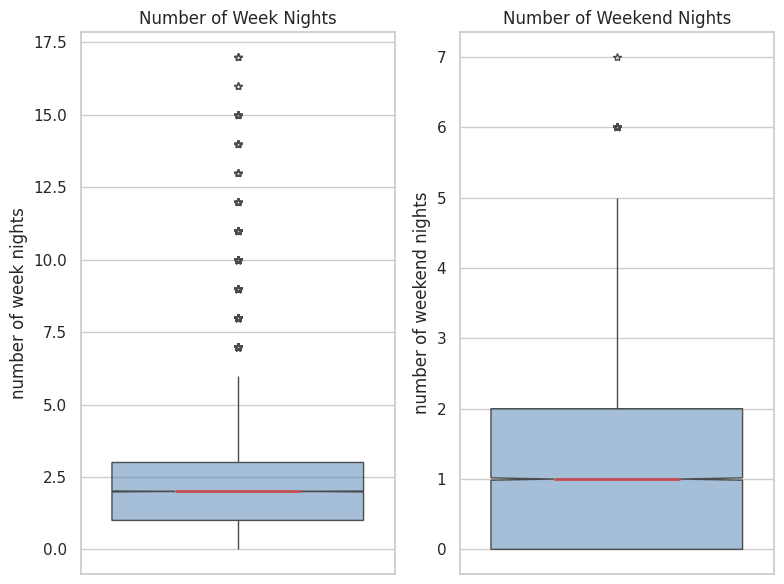

In [6]:
# Booking days of weekday & weekend Boxplots

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a boxplot for the number of week nights
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(y=data['number of week nights'],
            notch=True, showcaps=False,
            flierprops={"marker": "*"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2})
plt.title('Number of Week Nights')

# Create a boxplot for the number of weekend nights
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(y=data['number of weekend nights'],
            notch=True, showcaps=False,
            flierprops={"marker": "*"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2})
plt.title('Number of Weekend Nights')

# Show the plot
plt.tight_layout()
plt.show()


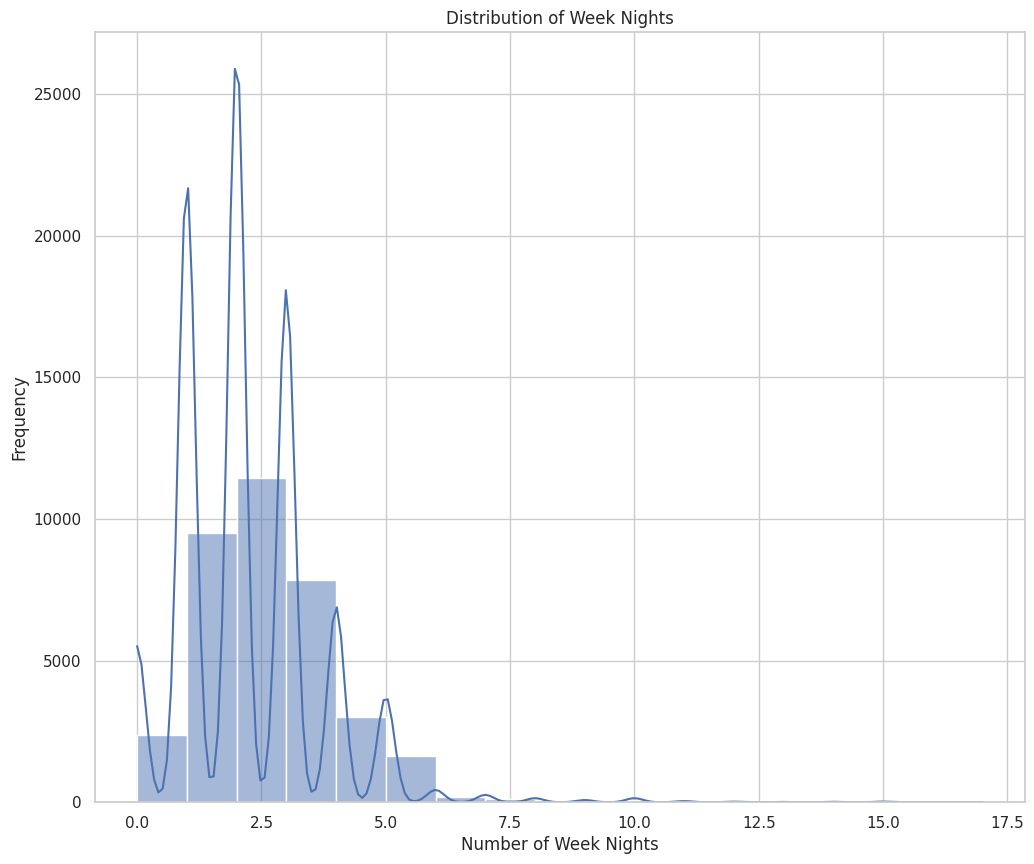

In [7]:
# Create a histogram by booking days

# Create a histogram for the number of week nights
plt.figure(figsize=(12, 10))
sns.histplot(data=data, x='number of week nights',
             binwidth=1,
             kde=True)
plt.title('Distribution of Week Nights')
plt.xlabel('Number of Week Nights')
plt.ylabel('Frequency')
plt.show()

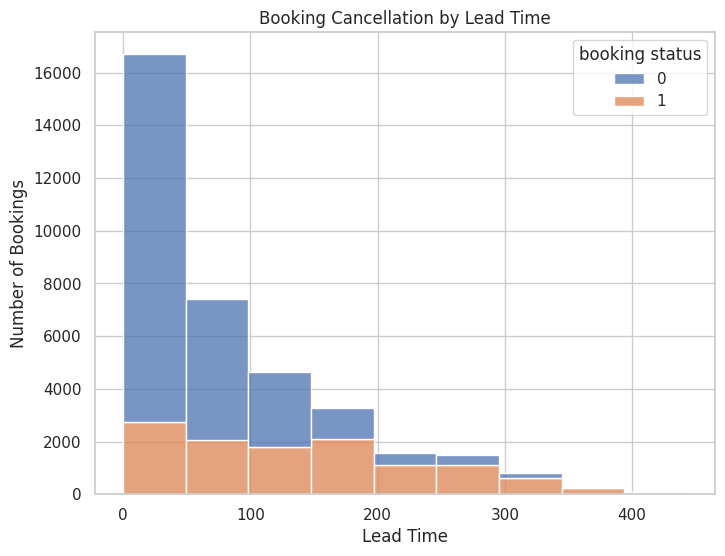

In [8]:
# Leadtimes by weekday & weekend hisplot

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a histogram
sns.histplot(x=data['lead time'],
            binwidth=50,
            hue=data['booking status'],
            multiple="stack")
plt.title('Booking Cancellation by Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Number of Bookings')
plt.show()

# 4.Linear Model Analysis

In [142]:
# Select features for the model
features = ['number of adults', 'number of children', 'number of weekend nights',
            'number of week nights', 'average price', 'lead time', 'P-C', 'P-not-C','special requests',
            'type of meal', 'car parking space', 'room type','market segment type', 'repeated']

X = data[features]
y = data['booking status']

Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64


In [143]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['number of adults', 'number of children', 'number of weekend nights',
            'number of week nights', 'average price', 'lead time', 'P-C', 'P-not-C','special requests']),
        ('cat', OneHotEncoder(drop='first', sparse=False), ['type of meal', 'car parking space', 'room type',
                                                            'market segment type', 'repeated'])
    ])

In [144]:
# Create a pipeline
from sklearn.feature_selection import RFE

rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('regressor', LinearRegression())
])

In [145]:
# Fit the model
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['number of adults',
                                                   'number of children',
                                                   'number of weekend nights',
                                                   'number of week nights',
                                                   'average price', 'lead time',
                                                   'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['type of meal',
                                                   'car parking space',
                                                   'room type',
                                                   'market segment type',
                                                   'repeated'])])),
                ('feature_selection',
                 RFE(estimator=LinearRegression(), n_features_to_select=10)),
                ('regressor', LinearRegression())])

In [146]:
# Make predictions
y_pred = model.predict(X_test)

In [147]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.2f}")
print(f"R-squared score: {r2:.2f}")

Mean squared error: 0.19
R-squared score: 0.14


In [148]:
# Feature importances
num_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out().tolist() if hasattr(preprocessor.named_transformers_['num'], 'get_feature_names_out') else []
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist() if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out') else []

feature_names = num_feature_names + cat_feature_names
coefficients = model.named_steps['regressor'].coef_

for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")

type of meal_1: 0.0713
type of meal_2: -0.2041
type of meal_3: 0.1694
car parking space_1: 0.1072
room type_2: -0.1529
room type_3: -0.0823
room type_4: -0.0725
room type_5: -0.0779
room type_6: 0.2218
room type_7: -0.0748


#5.Non Linear Model Analysis

In [108]:
# Convert three categorical variables to factors
features = ['lead time', 'average price', 'type of meal']
X = data[features]
y = data['booking status']

# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)


Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64


In [109]:
# Encode categorical variables
X = pd.get_dummies(X, columns=['type of meal'], drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [154]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

def plot_feature_importance(importance, names, model_name):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'Feature Importance ({model_name})')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()


scores = {}


## Decision Tree

In [157]:
# Decision Tree
# Create a Decision Tree model instance
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model
decision_tree.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_dt = decision_tree.predict(X_test_scaled)

Accuracy: 0.80
---------------------------------------------------------
Confusion Matrix: 
[[4213  642]
 [ 820 1582]]
---------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4855
           1       0.71      0.66      0.68      2402

    accuracy                           0.80      7257
   macro avg       0.77      0.76      0.77      7257
weighted avg       0.80      0.80      0.80      7257



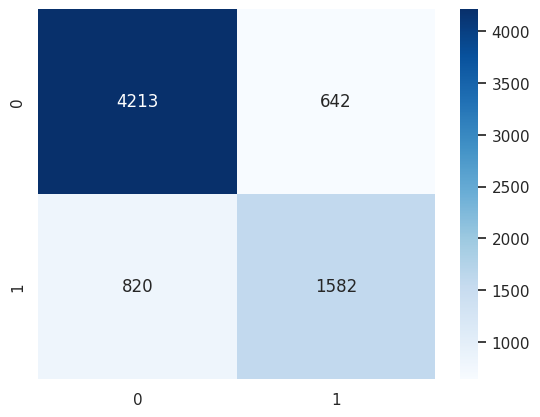

In [158]:
# Evaluate the model

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
scores["Decision Tree"] = accuracy_score(y_test, y_pred_dt)
print("---------------------------------------------------------")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_dt)}")
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, cmap="Blues", fmt=".0f")
print("---------------------------------------------------------")
print(f"Classification Report: \n{classification_report(y_test, y_pred_dt)}")


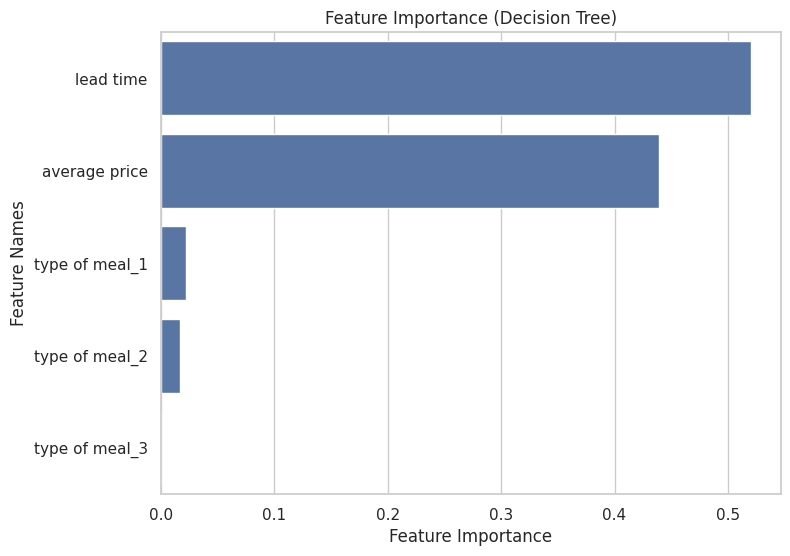

In [20]:
# Decision Tree Variable Importance
plot_feature_importance(decision_tree.feature_importances_, X.columns, 'Decision Tree')

## KNN

In [122]:
# K-nearest Neighbors
# Define the model
knn = KNeighborsClassifier()

# Define a range of potential n_neighbors to test
param_grid = {'n_neighbors': range(1, 101)}

# Set up GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [123]:
# Fit the grid search model
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 101)}, scoring='accuracy')

In [124]:
# Find best number of neighbors
best_n_neighbors = grid_search.best_params_['n_neighbors']
print("Best number of neighbors:", best_n_neighbors)

# Get the best score
best_score = grid_search.best_score_
print("Best accuracy score from cross-validation:", best_score)


Best number of neighbors: 2
Best accuracy score from cross-validation: 0.8062561020513099


In [160]:
# Create a KNN model
knn_best = KNeighborsClassifier(n_neighbors=2)

# Fit the model
knn_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn_best.predict(X_test_scaled)

Accuracy: 0.80
---------------------------------------------------------
Confusion Matrix: 
[[4569  286]
 [1131 1271]]
---------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      4855
           1       0.82      0.53      0.64      2402

    accuracy                           0.80      7257
   macro avg       0.81      0.74      0.75      7257
weighted avg       0.81      0.80      0.79      7257



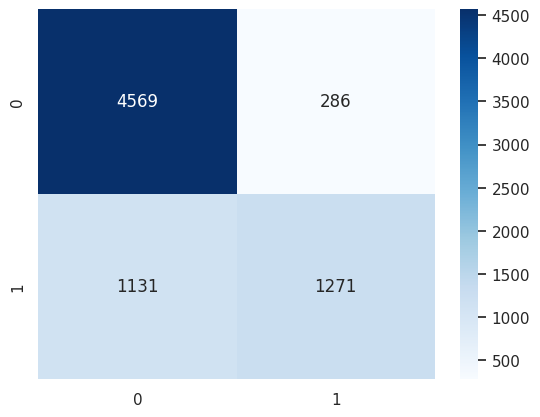

In [159]:
# Evaluate the model

print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")
scores["KNN"] = accuracy_score(y_test, y_pred_knn)
print("---------------------------------------------------------")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_knn)}")
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, cmap="Blues", fmt=".0f")
print("---------------------------------------------------------")
print(f"Classification Report: \n{classification_report(y_test, y_pred_knn)}")


## Bagged Trees

In [161]:
# Bagged Trees
# Create a Bagged Trees model
bagged_model = BaggingClassifier(random_state=42)

# Fit the model
bagged_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_bagged_model = bagged_model.predict(X_test_scaled)


Accuracy: 0.81
---------------------------------------------------------
Confusion Matrix: 
[[4304  551]
 [ 851 1551]]
---------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4855
           1       0.74      0.65      0.69      2402

    accuracy                           0.81      7257
   macro avg       0.79      0.77      0.77      7257
weighted avg       0.80      0.81      0.80      7257



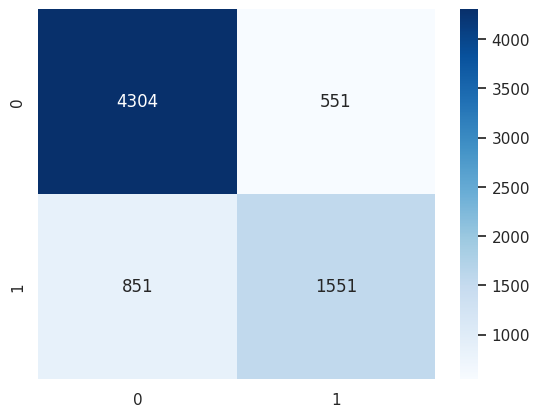

In [162]:
# Evaluate the model

print(f"Accuracy: {accuracy_score(y_test, y_pred_bagged_model):.2f}")
scores["Baggged Tree"] = accuracy_score(y_test, y_pred_bagged_model)
print("---------------------------------------------------------")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_bagged_model)}")
sns.heatmap(confusion_matrix(y_test, y_pred_bagged_model), annot=True, cmap="Blues", fmt=".0f")
print("---------------------------------------------------------")
print(f"Classification Report: \n{classification_report(y_test, y_pred_bagged_model)}")


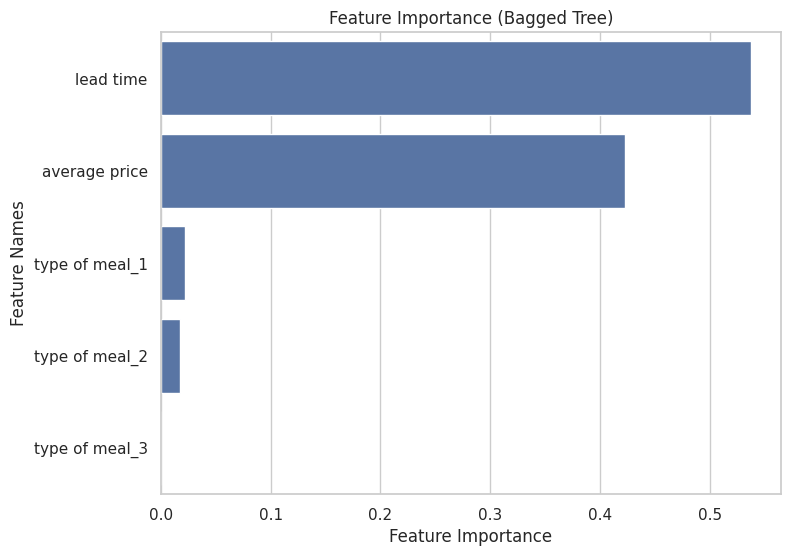

In [23]:
# Bagged Tree Variable Importance
bagged_importance = bagged_model.estimators_[0].feature_importances_
plot_feature_importance(bagged_importance, X.columns, 'Bagged Tree')

## Random Forest

In [163]:
# Random Forest
# Create a Random Forest model
rf_model = RandomForestClassifier(max_depth=20, n_estimators=20)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)


Accuracy: 0.81
---------------------------------------------------------
Confusion Matrix: 
[[4387  468]
 [ 897 1505]]
---------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      4855
           1       0.76      0.63      0.69      2402

    accuracy                           0.81      7257
   macro avg       0.80      0.77      0.78      7257
weighted avg       0.81      0.81      0.81      7257



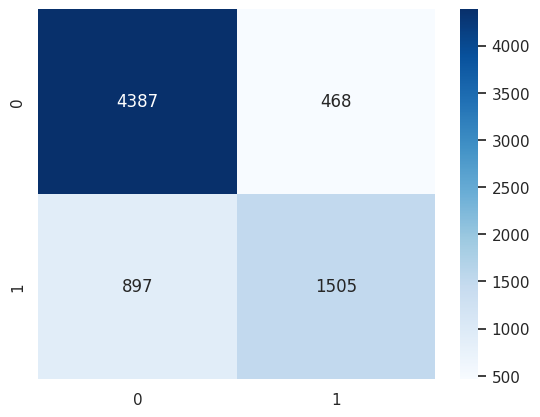

In [164]:
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
scores["Random Forest"] = accuracy_score(y_test, y_pred_rf)
print("---------------------------------------------------------")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_rf)}")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, cmap="Blues", fmt=".0f")
print("---------------------------------------------------------")
print(f"Classification Report: \n{classification_report(y_test, y_pred_rf)}")

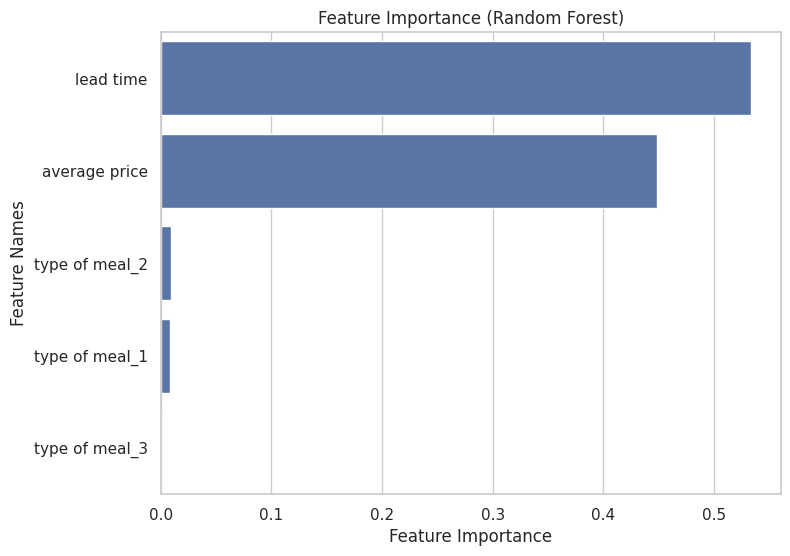

In [25]:
# Random Forest Variable Importance
plot_feature_importance(rf_model.feature_importances_, X.columns, 'Random Forest')

# 6.Models Comparison

## Accuracy Comparison


In [166]:
# Models Comparison
for model, score in scores.items():
    print(f"{model}: {score:.4f}")

Decision Tree: 0.7985
KNN: 0.8047
Baggged Tree: 0.8068
Random Forest: 0.8119


## ROC (Receiver Operating Characteristic) Curves

In [127]:
#Calculate the predicted probabilities for each model:
y_pred_proba_knn = knn_best.predict_proba(X_test)[:, 1]
y_pred_proba_dt = decision_tree.predict_proba(X_test)[:, 1]
y_pred_proba_bagged = bagged_model.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [132]:
#Calculate the ROC curve and AUC for each model
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_bagged, tpr_bagged, _ = roc_curve(y_test, y_pred_proba_bagged)
roc_auc_bagged = auc(fpr_bagged, tpr_bagged)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

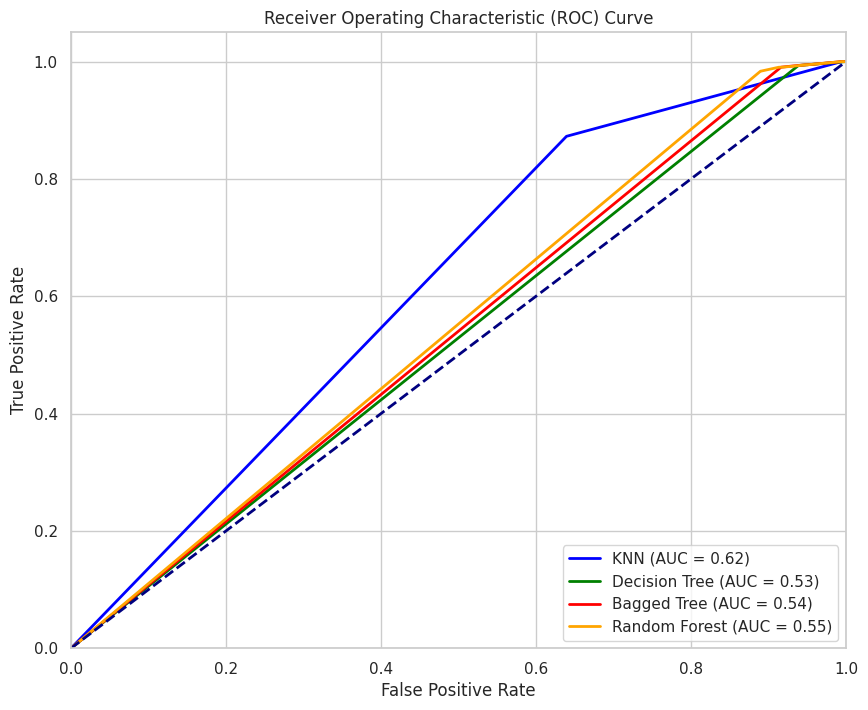

In [133]:
#Plot the ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_bagged, tpr_bagged, color='red', lw=2, label=f'Bagged Tree (AUC = {roc_auc_bagged:.2f})')
plt.plot(fpr_rf, tpr_rf, color='orange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()